In [ ]:
import pyspark
from pyspark.sql import SparkSession

# Create a Spark session (Control center of Spark functionality)
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [ ]:
spark.range(10).explain()
spark.range(10).show()

In [ ]:
# Print Spark configuration settings and version
print(spark.conf.get("spark.app.name"))
print(spark.conf.get("spark.sql.shuffle.partitions"))
print(spark.conf.get("spark.sql.files.maxPartitionBytes"))
print(spark.version)

In [ ]:
# Create a DataFrame with a range of numbers from 0 to 999
# Number is the name of the single column in the DataFrame (By default it's "id")
myRange = spark.range(1000).toDF("number")
myRange.show(5)

# Data structure are immutable

This is an example of a simple transformation
We can have to types of transformation

- narrow -> each input partition results in one output
- wide -> input partitions contribute to many output partitions


In [ ]:
divisBy2 = myRange.where("number % 2 = 0")  # narrowing transformation
divisBy2.show(5)
divisBy2.count()

# Actions

There are 3 types of actions

- to view data in console
- to collect data to native objects in their respective language
- to write to output data sources


# Spark UI

Monitor the progress of the job at:
http://localhost:4040

Or run spark.sparkContext.uiWebUrl


In [ ]:
spark.sparkContext.uiWebUrl

# Reading CSV files

Both styles of writing are correct

CSV file -> read
DataFrame -> take(n)
Array(row(),row())

CSV file -> read (narrow transformation)
DataFrame -> sort (wide transformation)
DataFrame -> take(3)
Array()

Nothing happens when we run sort because it's a transformation. However, Spark is building a plan on how to execute it across the cluster


In [ ]:
# Read a CSV file with header and infer schema
# inferSchema=True tells Spark to automatically detect data types, otherwise all columns are read as strings
bike_trip = spark.read.csv(
    "data/bike-data/201508_trip_data.csv",
    header=True,
    inferSchema=True
)

flight_data_2015 = spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("data/flight-data/csv/2015-summary.csv")

flight_data_2015.show(5)
flight_data_2015.take(5)
flight_data_2015.printSchema()

In [ ]:
# Spark uses lazy evaluation, so transformations are not executed until an action is called
# Spark.sort() is a transformation, while show() and take() are actions
flight_data_2015.sort("count").explain()
# This does not sort the data, just creates a new DataFrame with the sorting transformation applied
flight_data_2015.sort("count").show(5)
# flight_data_2015.show(5) will still show the unsorted data

# Shuffle

By default Spark outputs 200 shuffle partitions
A shuffle happens when Spark needs to redistribute data across the cluster, e.g.:

- groupBy
- join
- distinct
- orderBy / sort
- count after aggregation

During a shuffle:

- Data is split into shuffle partitions
- Each partition becomes a task

On a laptop or small dataset:

- 200 partitions → 200 tasks
- Each task has overhead
- Jobs look slow
- Spark UI shows tons of tiny tasks

Means:

- Only 5 shuffle tasks
- Less overhead
- Faster jobs
- Cleaner Spark UI

Good rule of thumb
shuffle partitions ≈ 2 × total executor cores – 4 × total executor cores

Local laptop (8 cores)
2 x 8 - 4 x 8 = between 16 and 32 partition

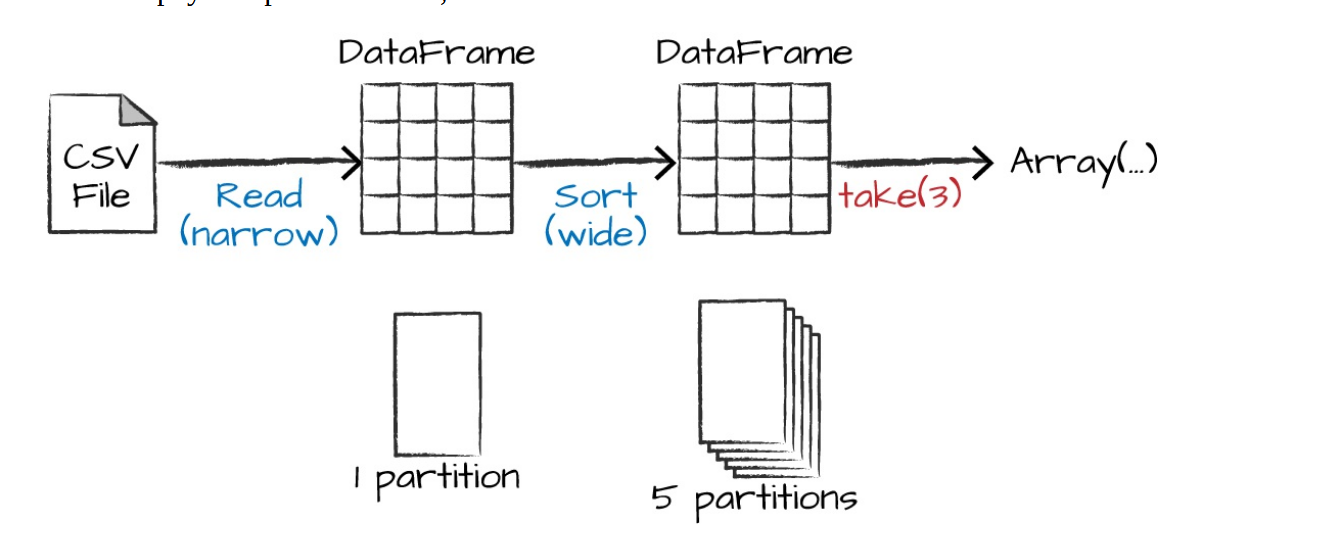


In [ ]:
import os

# Total logical cores
num_cores = os.cpu_count()
print(f"Total CPU cores (logical): {num_cores}")

In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", "5")
flight_data_2015.sort("count").take(2)

# DataFrames and SQL

You can express your business logic in SQL or DataFrames (R, Python, Scala or Java) adn Spark will compile the logic
You can register any DataFrame as a TABLE or a VIEW in query it in pure SQL
There is no performance difference between SQL queries and writing DataFrames code

You can make any DataFrame into a TABLE or a VIEW with


In [ ]:
flight_data_2015.createOrReplaceTempView("flight_data_2015")

Now we can query our data in SQL using the function `spark.sql`


In [ ]:
sqlWay = spark.sql("""
                   SELECT DEST_COUNTRY_NAME, count(1)
                   FROM flight_data_2015
                   GROUP BY DEST_COUNTRY_NAME
                   """)

dataFrameWay = flight_data_2015.groupBy("DEST_COUNTRY_NAME").count()

# Exact the same execution plan
sqlWay.explain()
dataFrameWay.explain()
# Exact the same results
sqlWay.show(5)
dataFrameWay.show(5)

In [ ]:
# Stop the Spark session - good practice to free up resources on low-RAM machines
spark.stop()